In [6]:
#Creamos la función preprocess_text
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

def preprocess_text(text):
    # Tokenización
    tokens = word_tokenize(text)

    # Lower case
    tokens = [token.lower() for token in tokens]

    # Eliminar caracteres especiales y números
    tokens = [re.sub(r'[^a-zA-Z]', '', token) for token in tokens]

    # Eliminar stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Quitar cadenas vacías
    tokens = [token for token in tokens if token]

    # Lematización
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

# Ejemplo de texto de correo electrónico
email_text = "Congratulations! You've won a free trip to Hawaii. Click here to claim your prize!"
print(email_text)
# Preprocesamiento del texto del correo electrónico
preprocessed_email = preprocess_text(email_text)
print("Texto preprocesado:", preprocessed_email)
print("Resultado deseado:",['congratulation', 'free', 'trip', 'hawaii', 'click', 'claim', 'prize'])

Congratulations! You've won a free trip to Hawaii. Click here to claim your prize!
Texto preprocesado: ['congratulation', 'free', 'trip', 'hawaii', 'click', 'claim', 'prize']
Resultado deseado: ['congratulation', 'free', 'trip', 'hawaii', 'click', 'claim', 'prize']


In [ ]:
# Aplicamos la funcion anterior a cada elemento de las listas con texto
df = pd.read_csv("spam_ham_dataset.csv")
df_2 = df.drop("Unnamed: 0",axis=1).drop("label",axis=1)
texto = df["text"]
labels = df["label_num"]
spam = df[df["label_num"]==1]["text"]
ham = df[df["label_num"]==0]["text"]

texto_2 = [preprocess_text(email) for email in texto]
spam_2 = [preprocess_text(email) for email in spam]
ham_2 = [preprocess_text(email) for email in ham]

# Obtenemos el conjunto de palabras unicas de spam
set_spam = set()
for email in spam_2:
  set_spam.update(set(email))

# Obtenemos el conjunto de palabras unicas de ham
set_ham = set()
for email in ham_2:
  set_ham.update(set(email))

dict_spamicity = {}
#Obtenemos la proba de que aparezca una palabra dado que es spam
#Iteramos sobre las palabras que aparecen en spam
# Iteramos sobre los correos de spam
total_spam = len(spam)
for palabra in set_spam:
  pInSpam = 0
  for email in spam_2:
    if palabra in email:
      pInSpam +=1
  if pInSpam ==0:
    proba = 1/total_spam # Parametro
  else:
    proba = pInSpam/total_spam
  dict_spamicity[palabra] = proba

dict_ham = {}
#Obtenemos la proba de que aparezca una palabra dado que es ham
#Iteramos sobre las palabras que aparecen en ham
# Iteramos sobre los correos de ham
total_ham = len(ham)
for palabra in set_ham:
  pInHam = 0
  for email in ham_2:
    if palabra in email:
      pInHam +=1
  if pInHam ==0:
    proba = 1/total_ham # Parametro
  else:
    proba = pInHam/total_ham
  dict_ham[palabra] = proba


# Calculamos la probabilidad de spam y ham
S = total_spam/(total_spam+total_ham)
H = total_ham/(total_spam+total_ham)

#Preparamos test individuales
tests  = ["""Subject: re : indian springs
this deal is to book the teco pvr revenue . it is my understanding that teco
just sends us a check , i haven ' t received an answer as to whether there is a
predermined price associated with this deal or if teco just lets us know what
we are giving . i can continue to chase this deal down if you need .""", """Subject: photoshop , windows , office . cheap . main trending
abasements darer prudently fortuitous undergone
lighthearted charm orinoco taster
railroad affluent pornographic cuvier
irvin parkhouse blameworthy chlorophyll
robed diagrammatic fogarty clears bayda
inconveniencing managing represented smartness hashish
academies shareholders unload badness
danielson pure caffein
spaniard chargeable levin"""]
tests = [preprocess_text(txt) for txt in tests]

# Quitamos de los emails las palabras que no encontramos
texto_preprocesado = []
for email in tests:
  email_nuevo = []
  for palabra in email:
    if palabra in set_ham:
      email_nuevo.append(palabra)
    else:
      if palabra in set_spam:
        email_nuevo.append(palabra)
  texto_preprocesado.append(email_nuevo)
texto_preprocesado

In [ ]:
# Preparamos tests para medir metricas
from sklearn.model_selection import train_test_split
X_, X_test, y_, y_test = train_test_split(texto_2, labels, test_size=0.33, random_state=42)

# Creamos funcion que reciba una lista de probabilidades, multiplique todas y regrese el resultado
def mult(probas) :        # multiplicar todas las probas
    total_prob = 1
    for proba in probas:
      total_prob*=proba
    # Multiplicar todas las probas
    return total_prob
# Creamos funcion que aplique Naive_Bayes a un email, con un threshold como parametro
def Naive_Bayes(email,threshold):
    probs = []
    S # prob_spam
    H # prob_ham
    # Iteramos sobre las palabras del email
    for palabra in email:

    # Calculamos la proba de PdadoS #*Si es 0 asignamos una probabilidad baja 1/(total_spam+2)
      try:
        PdadoS = dict_spamicity[palabra]
      except:
        PdadoS = 1/total_spam
    # Calculamos la proba de PdadoH #*Si es 0 asignamos una probabilidad baja 1/(total_spam+2)
      try:
          PdadoH = dict_ham[palabra]
      except:
          PdadoH = 1/total_ham
    # Aplicamos Bayes para obtener SdadoP
      probaB = PdadoS*S/(PdadoS*S+ PdadoH*H)
      probs.append(probaB)
    # Multiplicamos todas las probas para obtener el total de SdadoEmail
    SdadoEmail = mult(probs)
    # Aplicamos el Threshold para determinar si es o no es spam
    # print(SdadoEmail)
    if SdadoEmail >= threshold:
      SdadoEmail =1
    else:
      SdadoEmail = 0
    return SdadoEmail
for email in texto_preprocesado:
  print(Naive_Bayes(email,.00000000000001))

y_pred = [Naive_Bayes(email,.00000000000001) for email in X_test]

from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay
print(classification_report(y_test,y_pred))

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('ticks')
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot()
plt.title("Confusion Matrix")

Text(0.5, 1.0, 'Confusion Matrix')

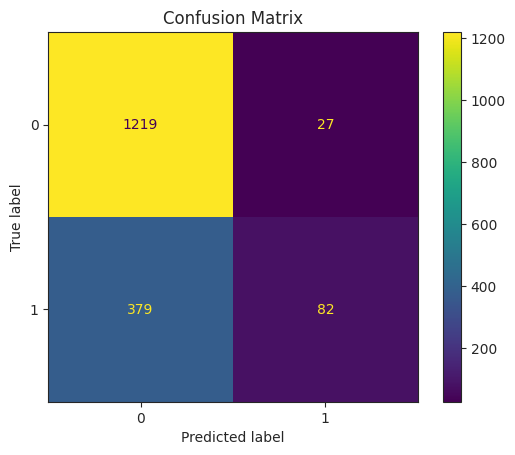

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('ticks')
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot()
plt.title("Confusion Matrix")